In [1]:
library(admixstats)

In [2]:
library(microbenchmark)
library(pryr)

In [3]:
source("../code/scrm_sim.R")

In [4]:
source("../code/bias_fitting.R")

In [5]:
real_eur <- load_estimates("../data/admixture_array_nea.tsv")

real_lm <- lm(nea ~ t_admix, data=real_eur, weights=snp_count)

In [7]:
options(repr.plot.width=8, repr.plot.height=4)

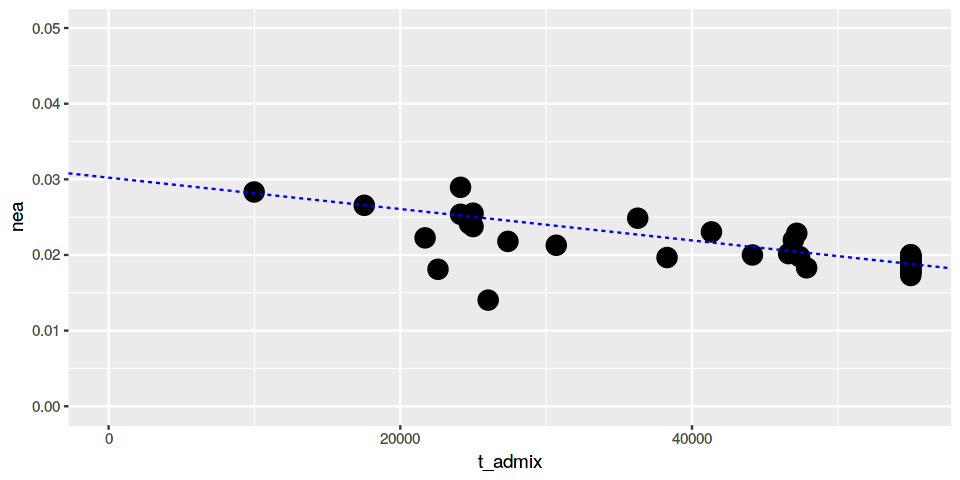

In [8]:
plot_nea(real_eur, real_lm)

In [8]:
p0 <- as.vector(coef(real_lm)[1])

In [9]:
x  <- microbenchmark({
    
all_sites <- simulate_sites(
  p0 = p0, m = 1e-4, t = 15000, d = 15000, Ne=10000,
  n_afr = 200, n_eur = nrow(filter(real_eur, pop != "EMH")),
  n_nea = 4, n_chimp = 1, n_haps = 25000, hap_length = 10001,
  emh_ages = filter(real_eur, pop == "EMH")$age
)

}, times=1)

In [10]:
print(x)

Unit: seconds
                                                                                                                                                                                                                                                                                                        expr
 {     all_sites <- simulate_sites(p0 = p0, m = 1e-04, t = 15000,          d = 15000, Ne = 10000, n_afr = 200, n_eur = nrow(filter(real_eur,              pop != "EMH")), n_nea = 4, n_chimp = 1, n_haps = 25000,          hap_length = 10001, emh_ages = filter(real_eur, pop ==              "EMH")$age) }
      min       lq     mean   median       uq      max neval
 367.3726 367.3726 367.3726 367.3726 367.3726 367.3726     1


In [11]:
admix_array <- archaic_admixture_array(all_sites)
bigyri_array <- big_yoruba_array(all_sites)

In [13]:
nrow(admix_array)
nrow(bigyri_array)

[1] 235913

[1] 449230

In [14]:
aa_sim <- admix_prop(admix_array, real_eur$name) %>% inner_join(select(real_eur, -nea))
aa_lm <- nea_lm(aa_sim)

Joining, by = "name"


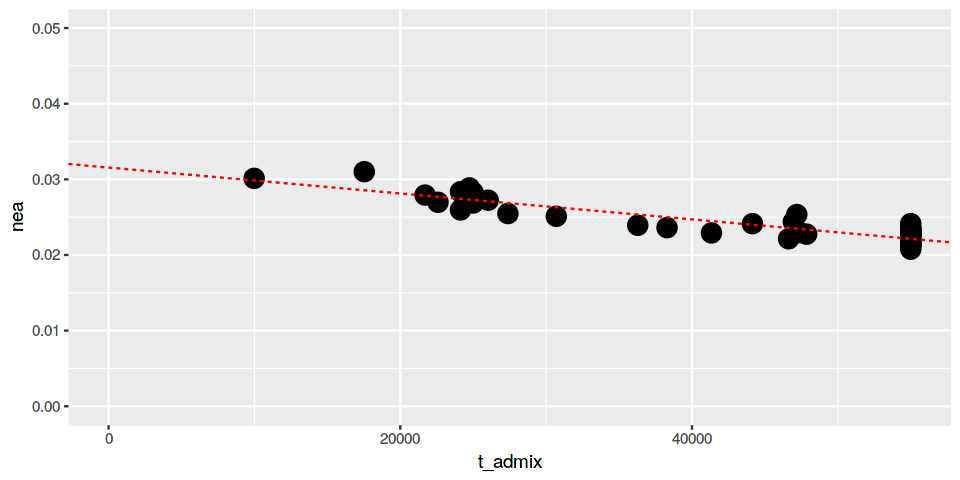

In [15]:
plot_nea(aa_sim, sim_lm = aa_lm)

In [16]:
by_sim <-
    tibble(name=real_eur$name,
           nea=map_dbl(real_eur$name, ~ f4_ratio(bigyri_array,
                                                 x=., a=paste0("nea_", 1:2), b=paste0("nea_", 3:4),
                                                 c=paste0("afr_", 1:10), o="chimp_1"))) %>%
    inner_join(select(real_eur, -nea))
by_lm <- nea_lm(by_sim)

Joining, by = "name"


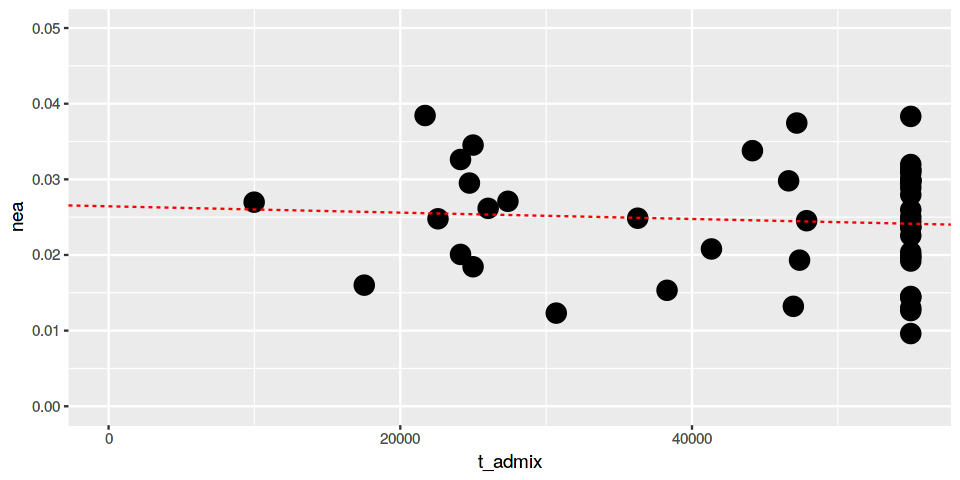

In [18]:
plot_nea(by_sim, sim_lm = by_lm)

In [1]:
library(admixstats)
library(tidyverse)
library(parallel)
library(magrittr)
library(broom)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1     ✔ purrr   0.2.4
✔ tibble  1.4.2     ✔ dplyr   0.7.4
✔ tidyr   0.8.0     ✔ stringr 1.2.0
✔ readr   1.1.1     ✔ forcats 0.2.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘magrittr’

The following object is masked from ‘package:purrr’:

    set_names

The following object is masked from ‘package:tidyr’:

    extract



In [2]:
source("../code/scrm_sim.R")

In [3]:
source("../code/bias_fitting.R")

In [4]:
real_eur <- load_estimates("../data/admixture_array_nea.tsv")

real_lm <- lm(nea ~ t_admix, data=real_eur, weights=snp_count)

In [5]:
p0 <- as.vector(coef(real_lm)[1])

In [6]:
run_sim <- function(m_afr_eur, m_eur_afr) {
    
mclapply(mc.cores=10, 1:10, function(rep_i) {
    res_df <- data.frame()

    for (Ne in c(2000, 5000, 10000, 20000)) {

    all_sites <- simulate_sites(
        p0 = p0, m_afr_eur, m_eur_afr, t = 15000, d = 15000, Ne,
        n_afr = 200, n_eur = nrow(filter(real_eur, pop != "EMH")),
        n_nea = 4, n_chimp = 1, n_haps = 120000, hap_length = 5001,
        emh_ages = filter(real_eur, pop == "EMH")$age
    )
    
    admix_array <- archaic_admixture_array(all_sites)
    bigyri_array <- big_yoruba_array(all_sites)
    
    aa_sim <- admix_prop(admix_array, real_eur$name) %>% mutate(stat="admix_array")
    by_sim <-
        tibble(name=real_eur$name,
               nea=map_dbl(real_eur$name, ~ f4_ratio(bigyri_array,
                                                     x=., a=paste0("nea_", 1:2), b=paste0("nea_", 3:4),
                                                     c=paste0("afr_", 1:10), o="chimp_1")),
               stat="f4_ratio")
    
    res <- bind_rows(aa_sim, by_sim) %>% mutate(rep=rep_i, Ne=Ne)
    
    res_df %<>% bind_rows(res)

    }
    
    res_df
}) %>% bind_rows

}

In [7]:
res <- bind_rows(
    run_sim(m_afr_eur = 0,    m_eur_afr = 0)    %>% mutate(scenario = "no migration"),
    run_sim(m_afr_eur = 1e-4, m_eur_afr = 0)    %>% mutate(scenario = "AFR -> EUR"),
    run_sim(m_afr_eur = 0,    m_eur_afr = 1e-4) %>% mutate(scenario = "EUR -> AFR"),
    run_sim(m_afr_eur = 1e-4, m_eur_afr = 1e-4) %>% mutate(scenario = "EUR <-> AFR")
)

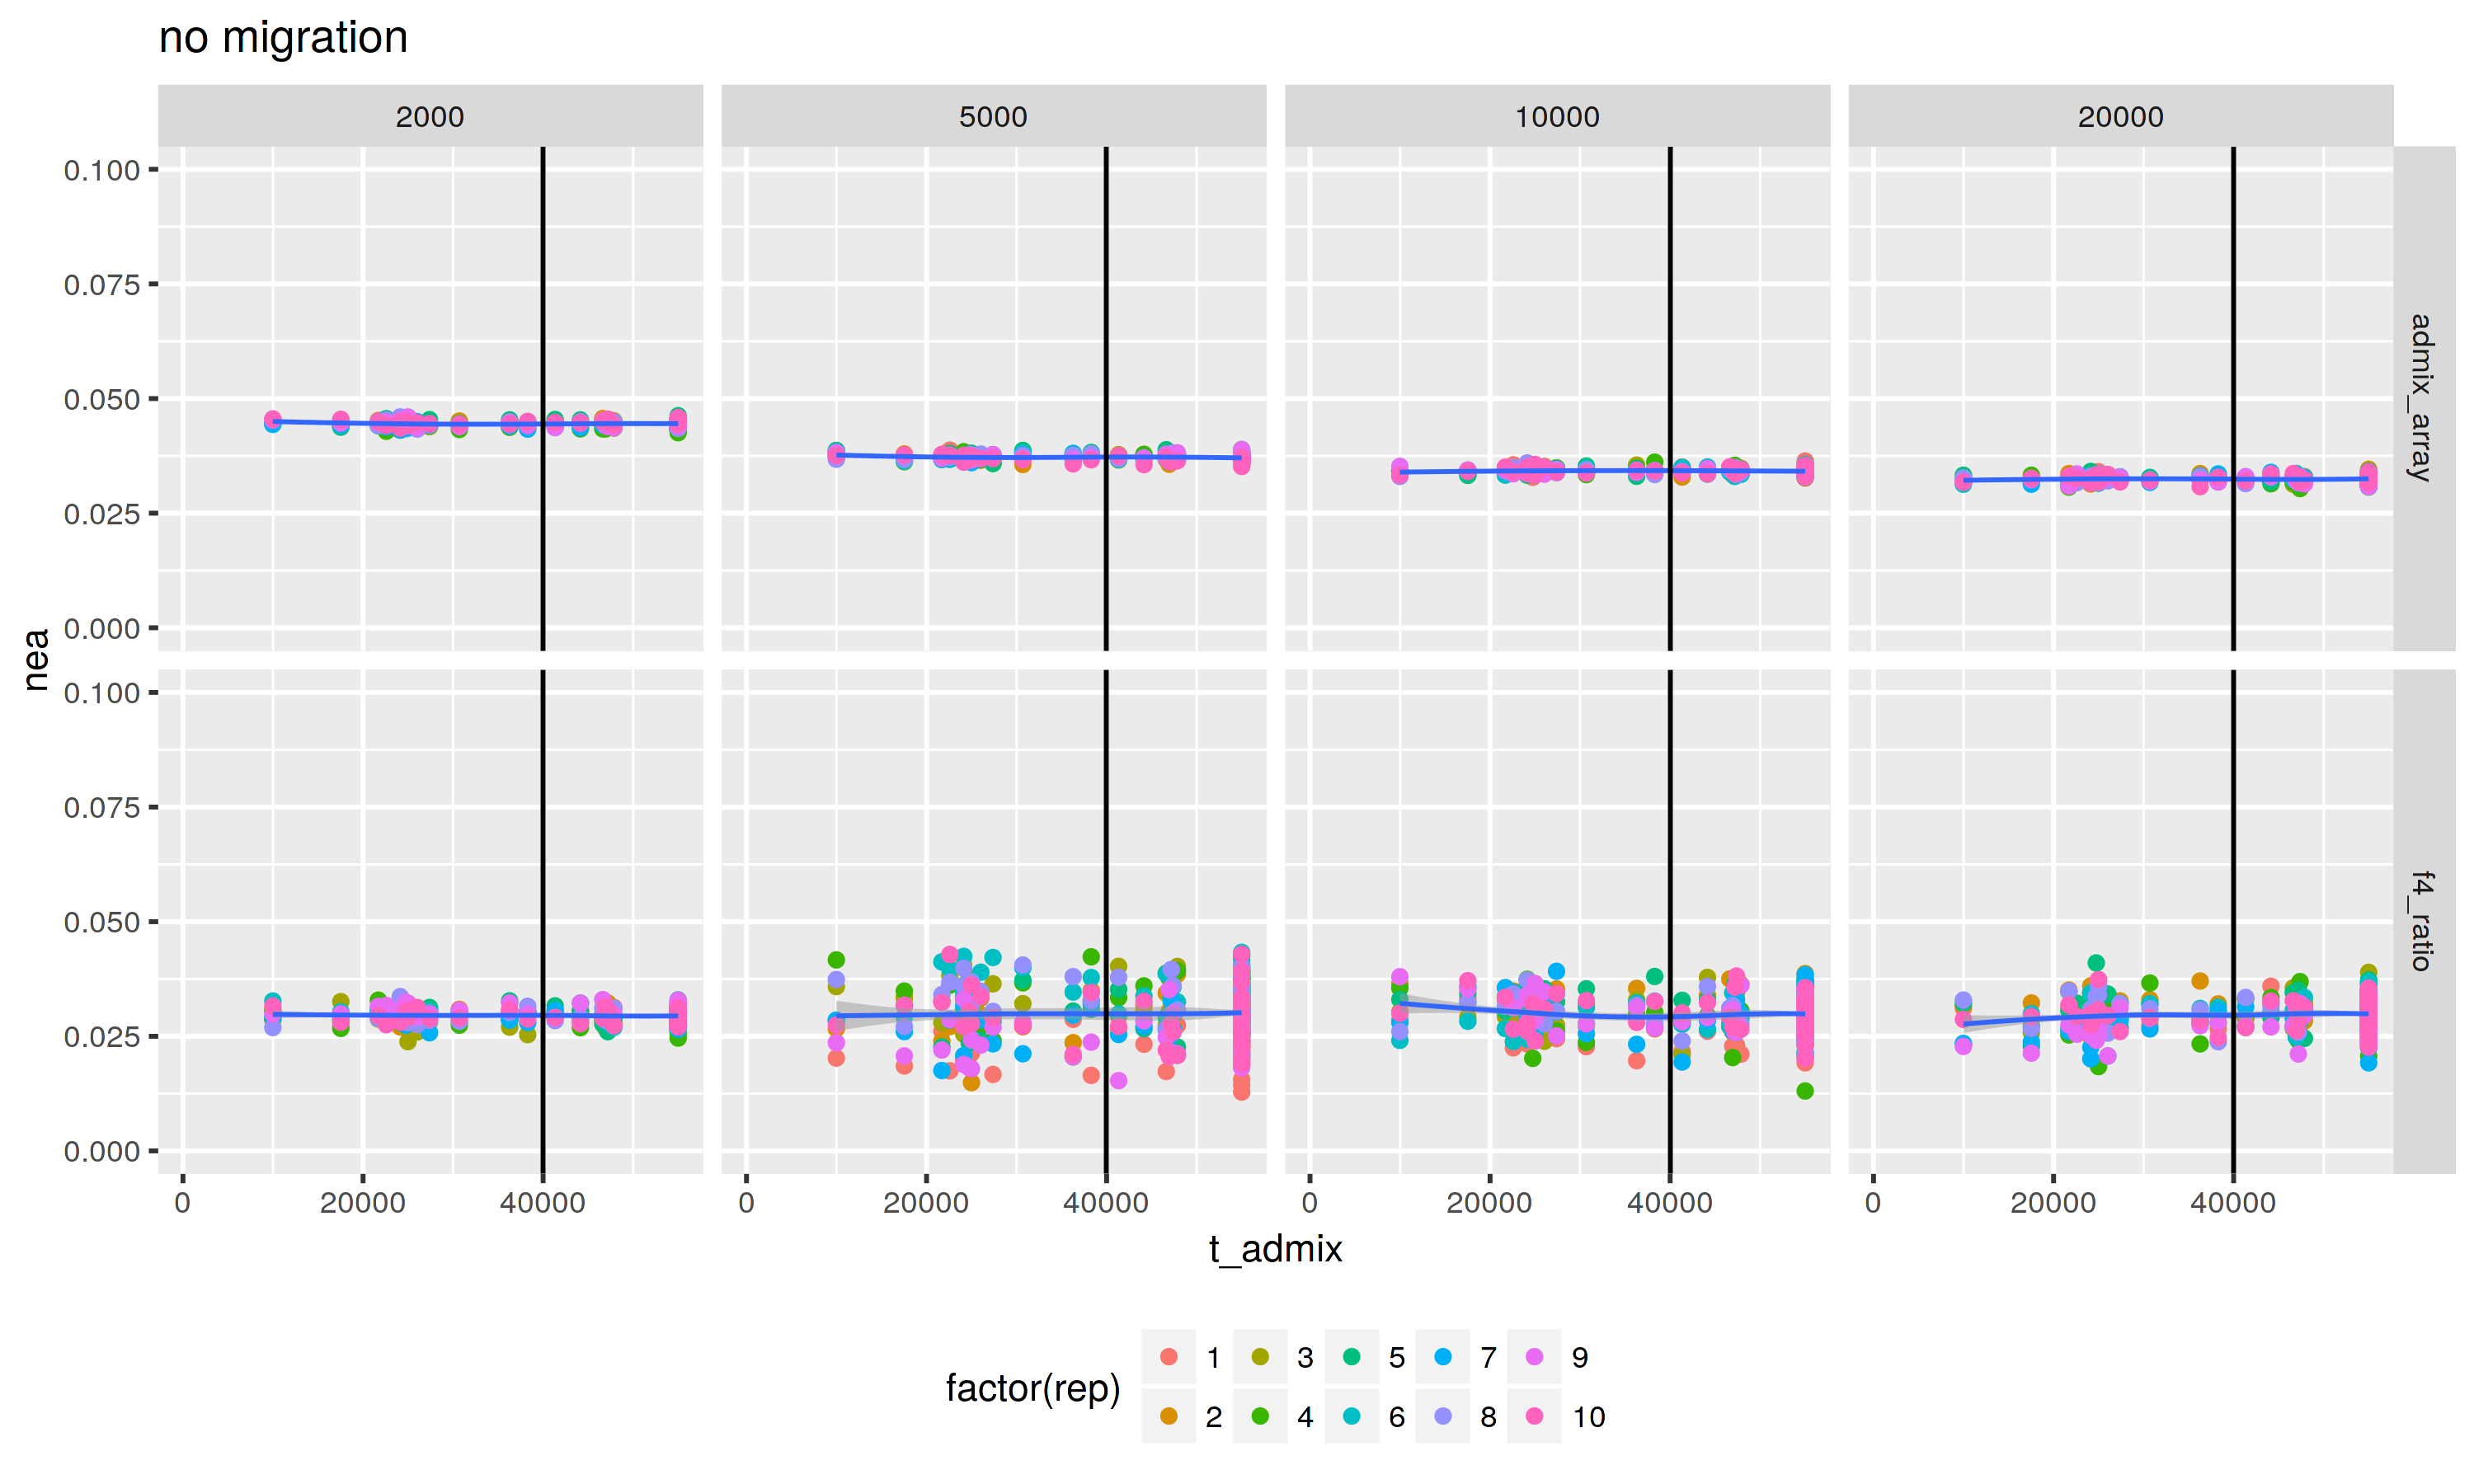

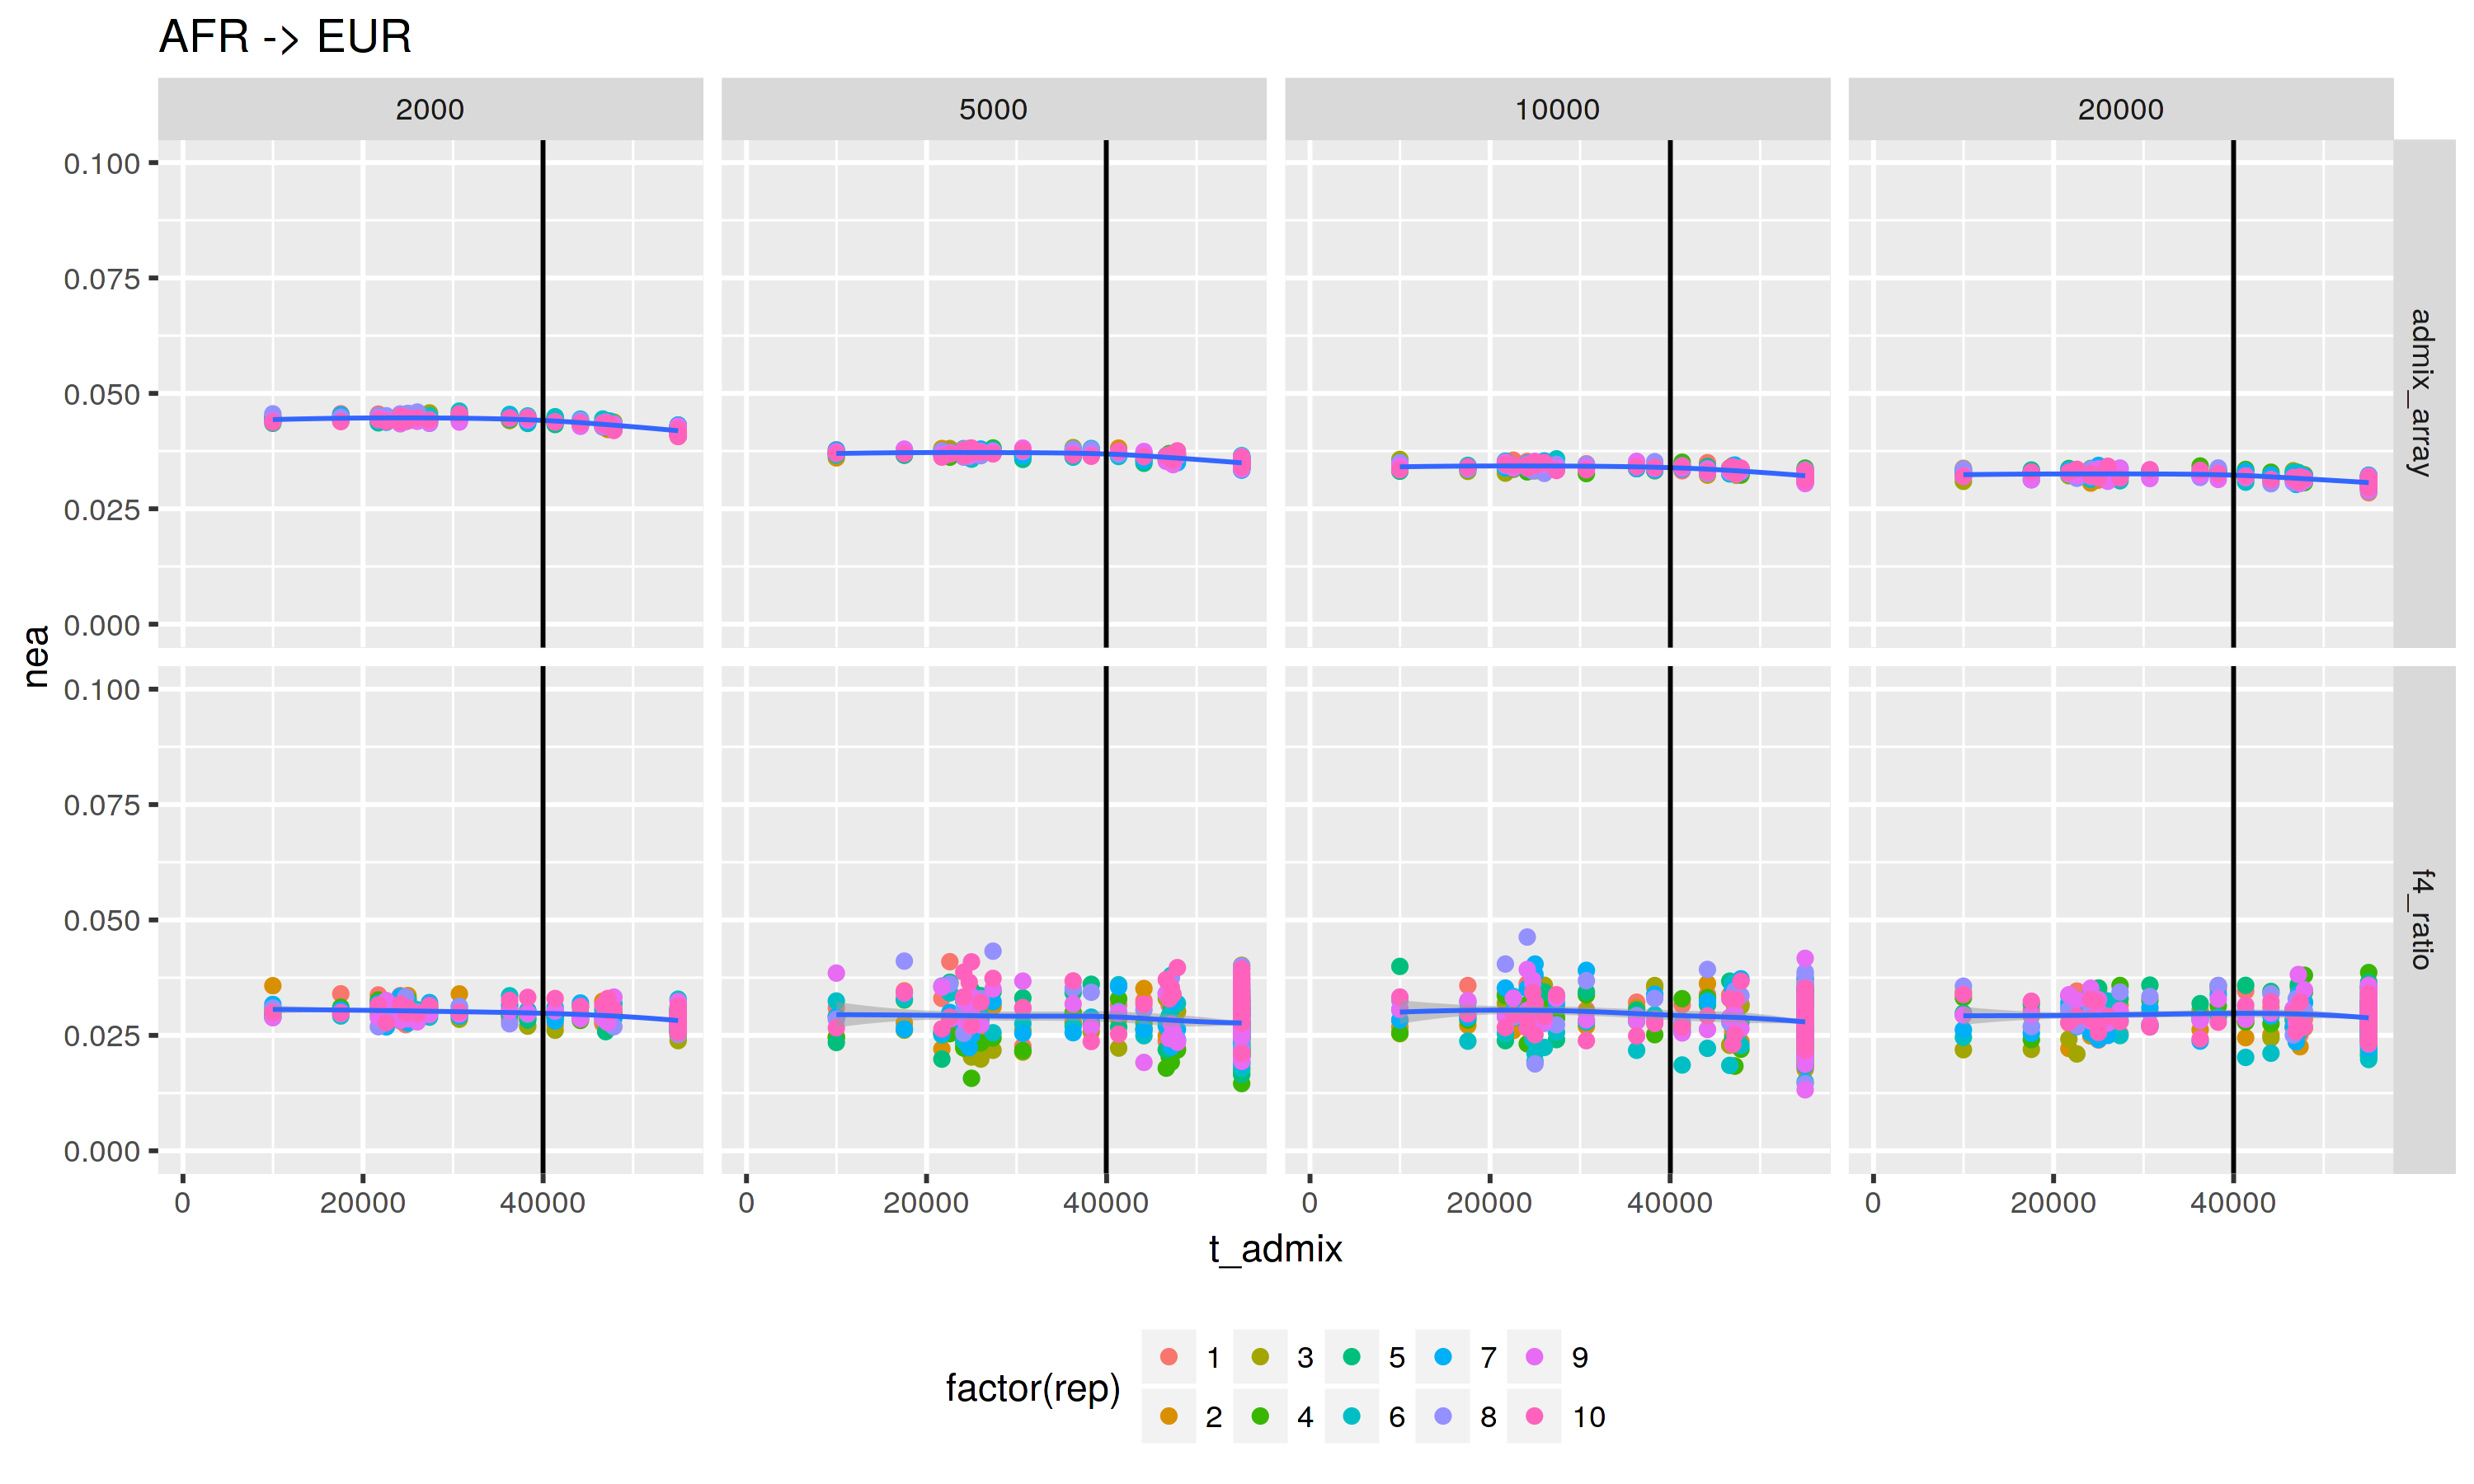

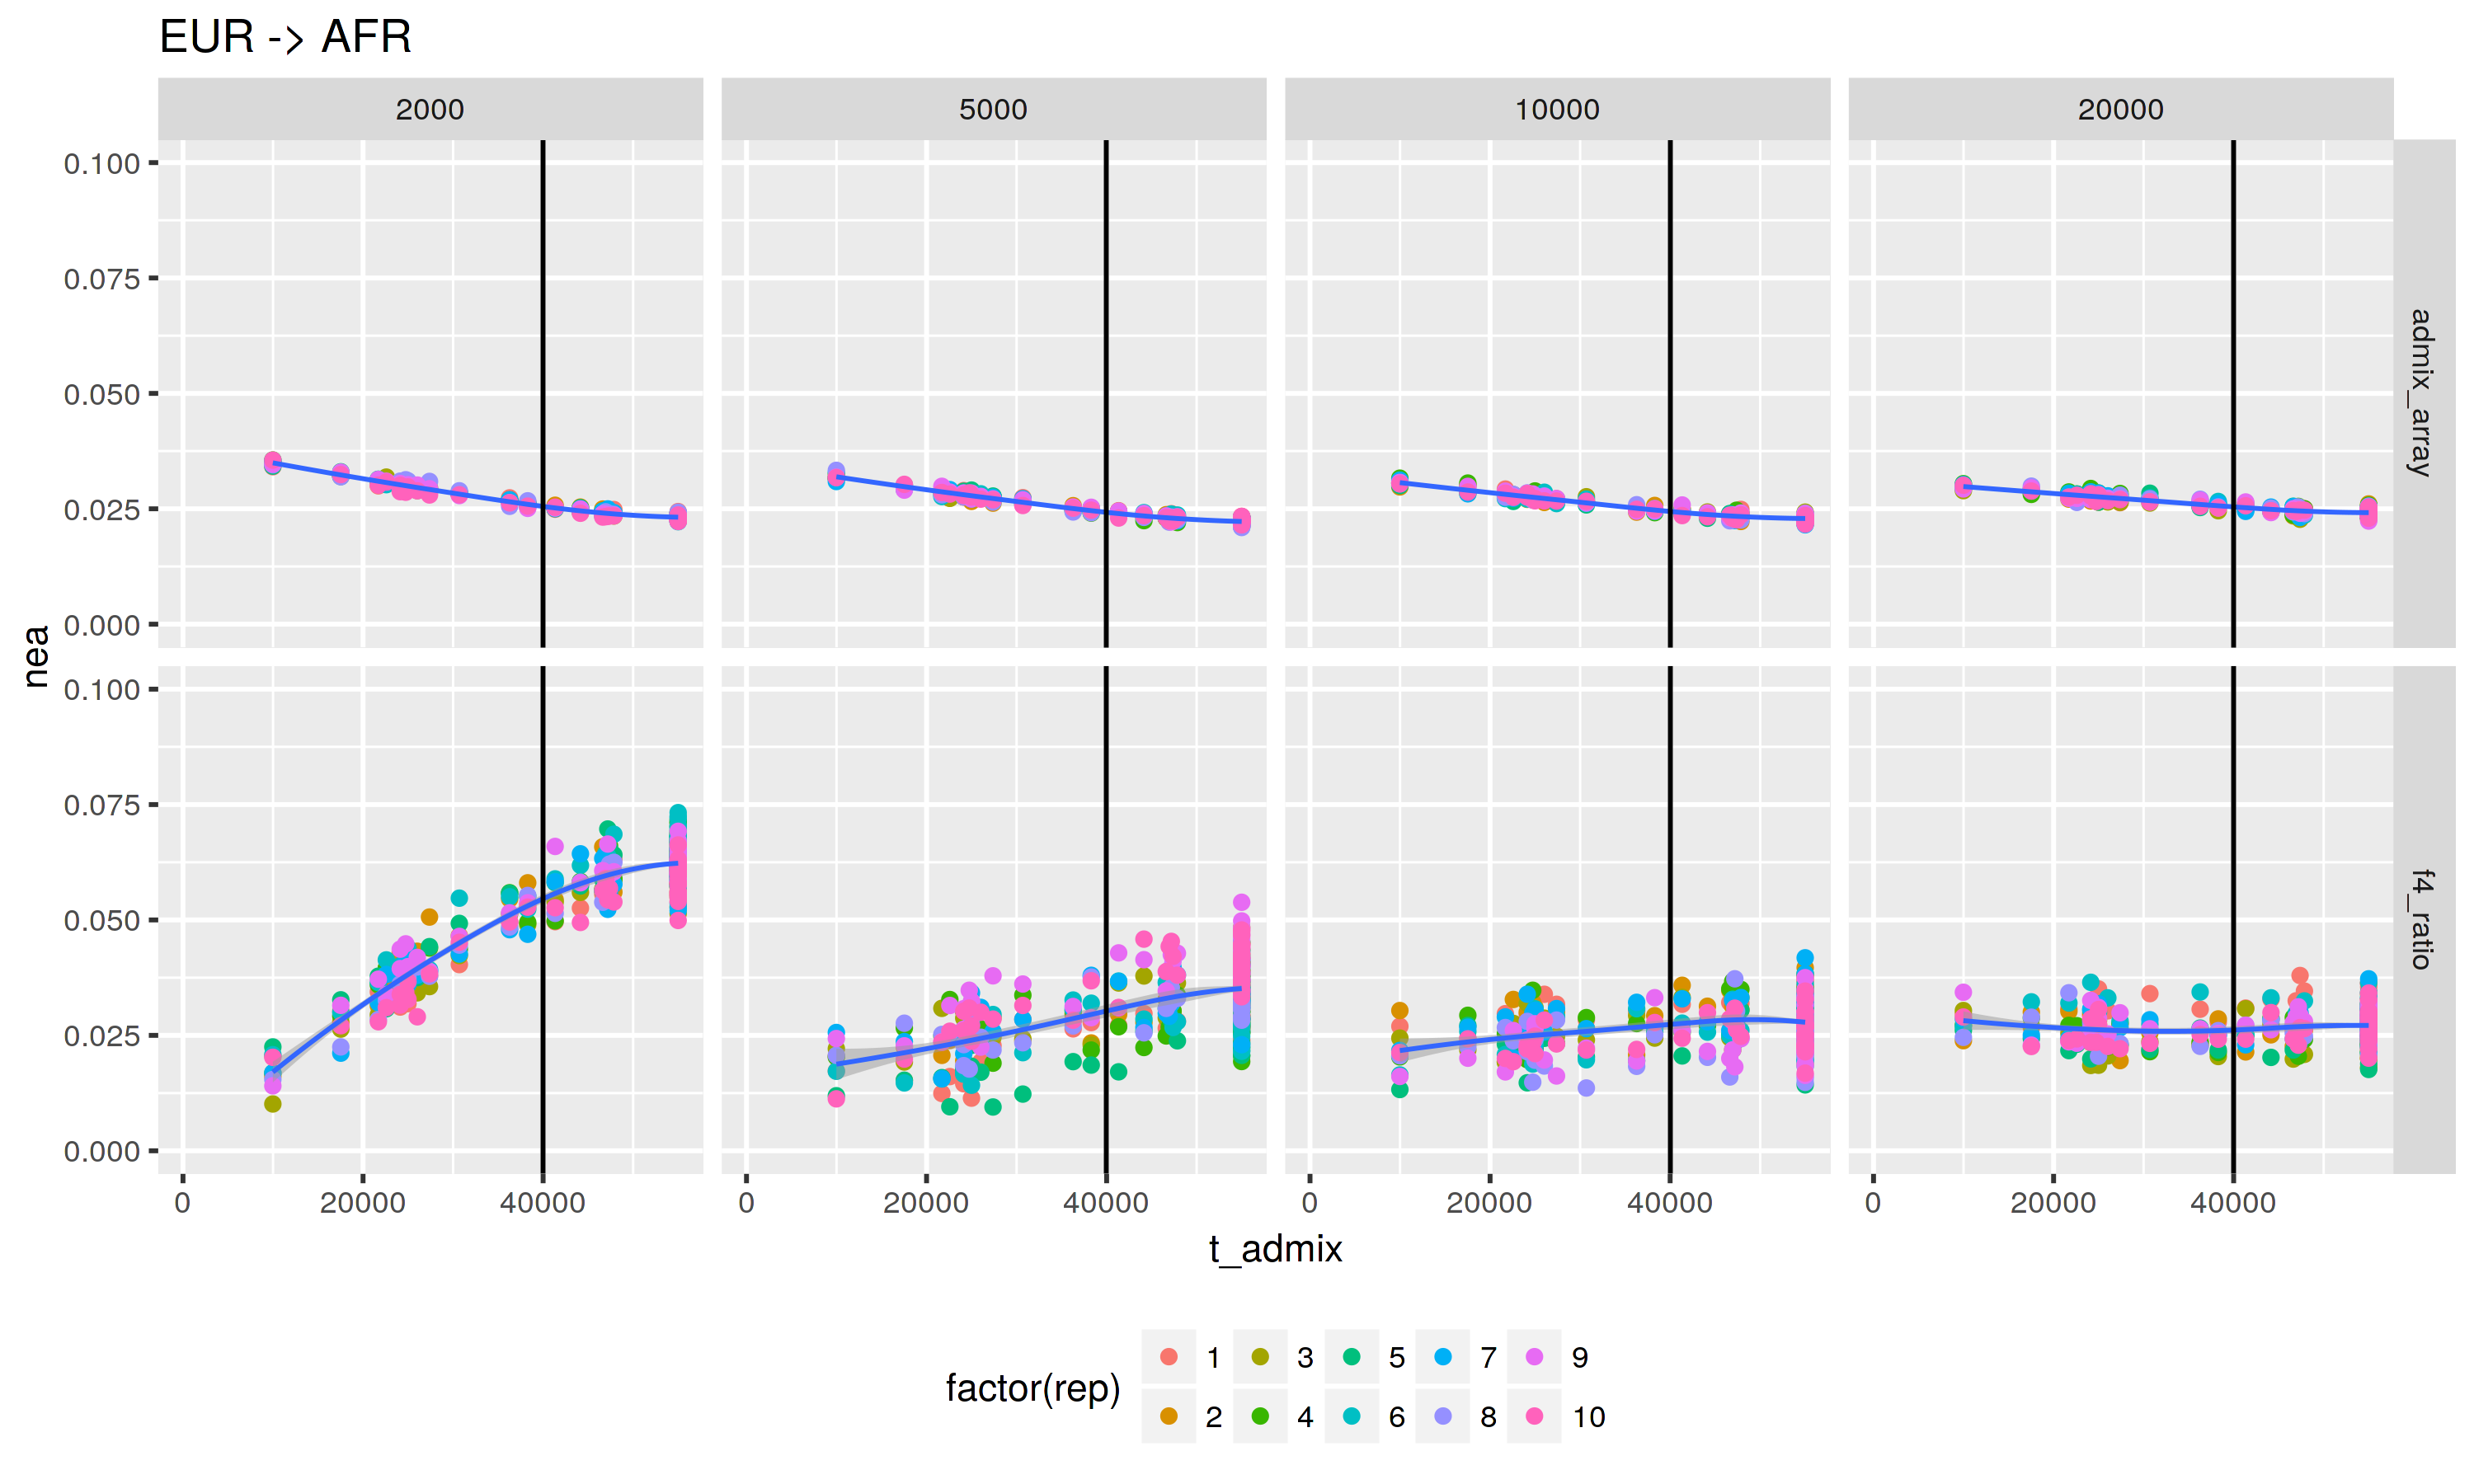

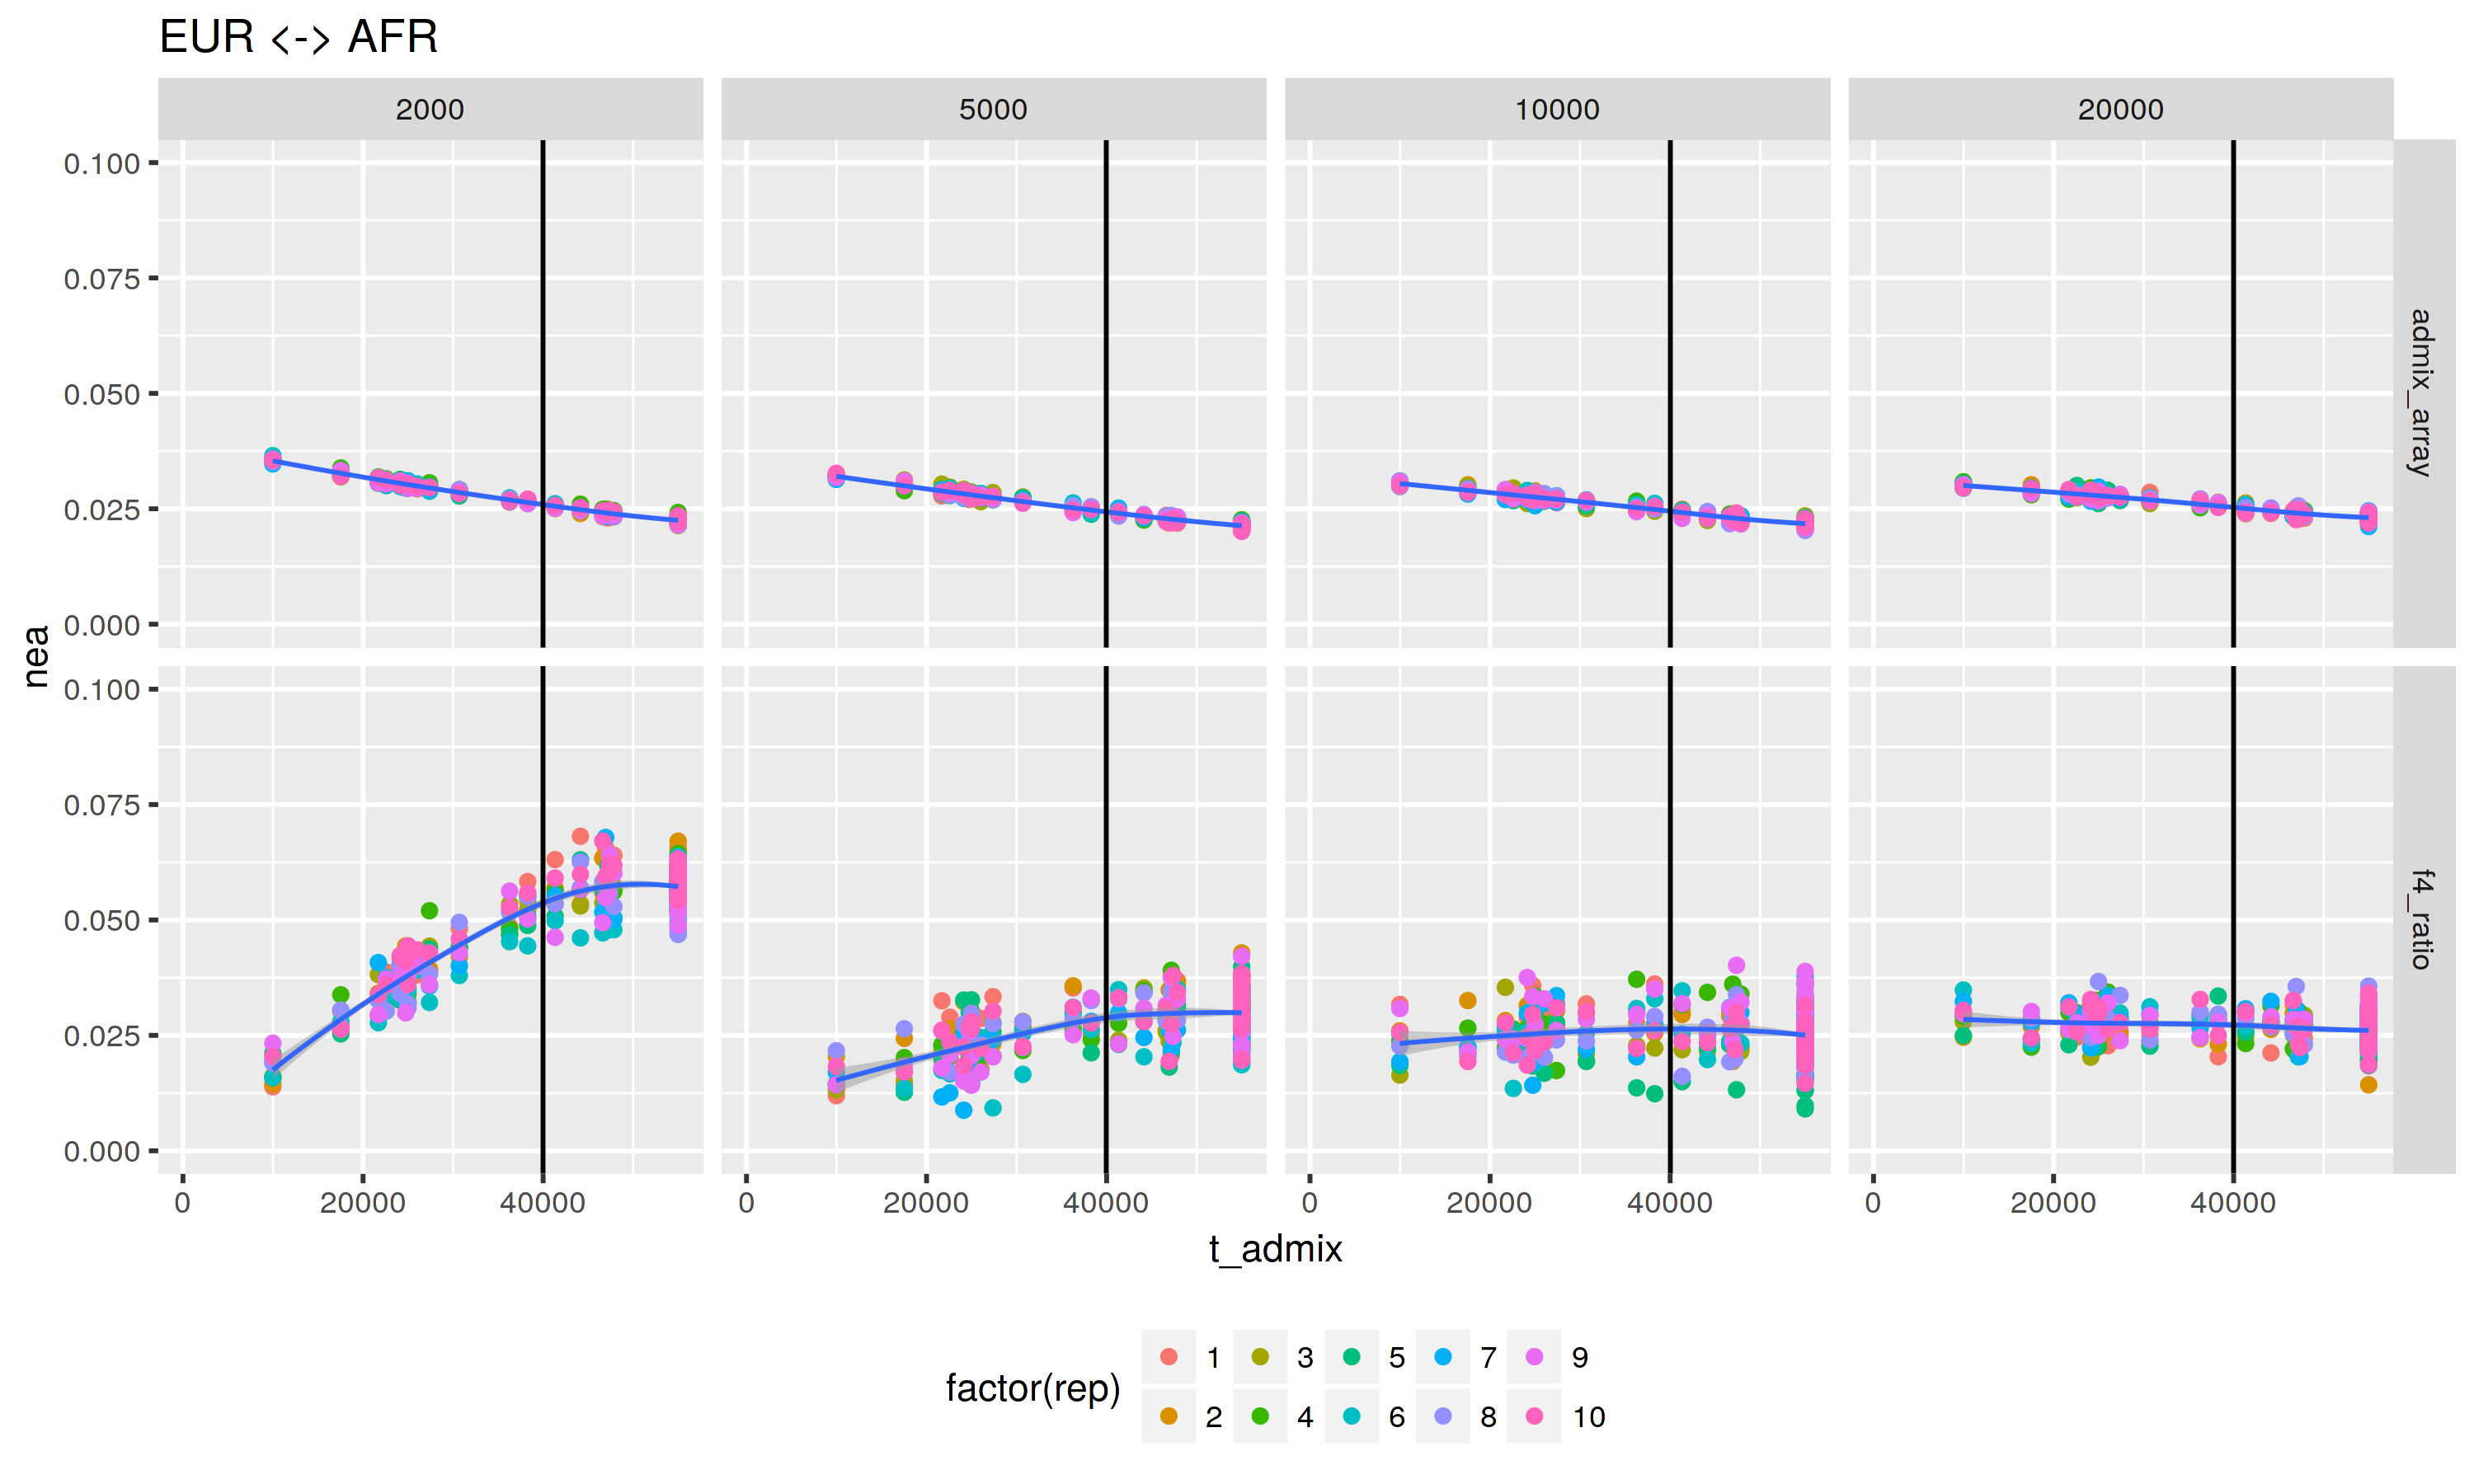

In [29]:
options(repr.plot.width=10, repr.plot.height=6, repr.plot.res=300)

for (s in unique(res$scenario)) {
{ res %>% filter(scenario == s) %>%
inner_join(select(real_eur, -nea), by="name") %>%
ggplot(aes(t_admix, nea)) +
    geom_point(aes(color=factor(rep))) +
    geom_smooth(method="loess", size=0.5, alpha=1/2) +
    geom_vline(xintercept=55000-15000) + ggtitle(s) +
    facet_grid(stat ~ Ne) + ylim(0, 0.1) + xlim(0, 55000) + theme(legend.position="bottom")
} %>%
print()
}